In [6]:
### IMPORT LIBRARYS ### 

import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import time

%matplotlib inline

In [7]:
def load_dataset():
    train_dataset = h5py.File('data/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('data/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [8]:
### Loading the data (cat/non-cat) ###
train_set_x_orig, Y, test_set_x_orig, y, classes = load_dataset()

In [9]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(Y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [11]:
### Reshape the training and test examples ###

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

#This a shorter way of expressing the long form .reshape:
#train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],train_set_x_orig.shape[1]*train_set_x_orig.shape[2]*train_set_x_orig.shape[3]).T
#test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0],test_set_x_orig.shape[1]*test_set_x_orig.shape[2]*test_set_x_orig.shape[3]).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(Y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

### STANDARDIZE THE DATASET ###
X = train_set_x_flatten/255.
x = test_set_x_flatten/255.

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


### DEFINING HELPER FUNCTIONS ###

In [12]:
# SIGMOID
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1/(1+np.exp(-z))
    
    return s

In [13]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0]# size of input layer
    n_h = 4 # hard code hidden layer size
    n_y = Y.shape[0] # size of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [14]:
n_x, n_h, n_y = layer_sizes(X,Y)
layer_sizes(X,Y)

(12288, 4, 1)

In [15]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(n_h,n_x)*.001
    b1 = np.zeros((n_h,1))
    W2 = np.random.randn(1,n_h)*.001
    b2 = np.zeros((1,1))
    ### END CODE HERE ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### FORWARD AND BACKWARD PROPAGATION ###

In [16]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    ### END CODE HERE ###
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1) + b2
    A2 = sigmoid(Z2)
    ### END CODE HERE ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [17]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    [Note that the parameters argument is not used in this function, 
    but the auto-grader currently expects this parameter.
    Future version of this notebook will fix both the notebook 
    and the auto-grader so that `parameters` is not needed.
    For now, please include `parameters` in the function signature,
    and also when invoking this function.]
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    ### START CODE HERE ### (≈ 2 lines of code)
    #logprobs = np.multiply(np.log(A2),Y)
    #cost =  - np.sum(logprobs)
    logprobs = np.multiply(np.log(A2),Y) + np.multiply((1-Y), np.log(1-A2))
    cost =  -(1/Y.shape[1])*np.sum(logprobs)
    ### END CODE HERE ###
    
    cost = float(np.squeeze(cost))  # makes sure cost is the dimension we expect. 
                                    # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [18]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters['W1']
    W2 = parameters['W2']
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 = cache['A1']
    A2 = cache['A2']
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    dZ2 = A2 - Y
    dW2 = (1/m)*np.dot(dZ2,A1.T)
    db2 = (1/m)*np.sum(dZ2, axis = 1, keepdims = True)
    dZ1 = W2.T*dZ2*(1 - np.power(A1, 2))
    dW1 = (1/m)*np.dot(dZ1,X.T)
    db1 = (1/m)*np.sum(dZ1, axis = 1, keepdims = True)
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [19]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate = 1.2):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [42]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters
    ### START CODE HERE ### (≈ 1 line of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### END CODE HERE ###
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2, Y, parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, .005)
        
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
            
    return parameters

In [40]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X, parameters)
    predictions = np.round(A2)
    ### END CODE HERE ###
    
    return predictions

In [41]:
    parameters = nn_model(X, Y, n_h, num_iterations = 10000, print_cost = True)
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(parameters, x)
    Y_prediction_train = predict(parameters, X)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - y)) * 100))

Cost after iteration 0: 0.693171
Cost after iteration 1000: 0.663283
Cost after iteration 2000: 0.646305
Cost after iteration 3000: 0.643582
Cost after iteration 4000: 0.630995
Cost after iteration 5000: 0.590939
Cost after iteration 6000: 0.528928
Cost after iteration 7000: 0.455881
Cost after iteration 8000: 0.379047
Cost after iteration 9000: 0.307630
train accuracy: 96.17224880382776 %
test accuracy: 70.0 %


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


y = 1.0, my algorithm predicts a "cat" picture.


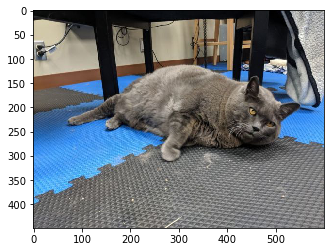

In [35]:
#(PUT YOUR IMAGE NAME) 
my_image = "bigblob.jpg"   # change this to the name of your image file 

# We preprocess the image to fit your algorithm.
fname = "data/" + my_image
#image = np.array(ndimage.imread(fname, flatten=False))
image = np.array(plt.imread(fname))
image = image/255.
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((1, num_px*num_px*3)).T
my_predicted_image = predict(parameters, my_image)

plt.imshow(image)
print("y = " + str(np.squeeze(my_predicted_image)) + ", my algorithm predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")